<a href="https://colab.research.google.com/github/roni762583/CandlesData/blob/master/vq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 56kB/s 
     |████████████████████████████████| 3.8MB 46.1MB/s 
     |████████████████████████████████| 450kB 50.7MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
print(tf.__version__)

2.0.0-dev20191002


LOAD DATA - Ref: https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9

In [3]:
#clone data
! git clone https://github.com/roni762583/CandlesData.git

Cloning into 'CandlesData'...
remote: Enumerating objects: 45, done.
remote: Total 45 (delta 0), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (45/45), done.


processing instrument 2 ...
processing instrument 3 ...
processing instrument 4 ...
processing instrument 5 ...
processing instrument 6 ...


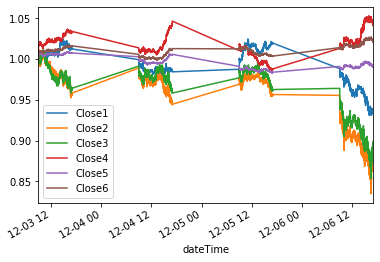

In [5]:
###################### GRAPH THE DATA TO EXPLORE #######################
# Build dataframe to graph closing prices, delta, log of delta
graphingDF = pd.DataFrame() #final DF
concatCloseDF = pd.DataFrame()
#loop over data files by instrument and day to form dataframe
days = range(3,7) # days of month: 3 - 6 inclusive (4-days)
instruments = range(1,7) # 6 instruments (6th is target)
for inst in instruments:
    #gdf add column for each inst. close 
    colStr = 'c'+ str(inst)
    for day in days:
        #build data file name pattern
        fileName = "INST"+str(inst)+"_2018-12-0"+str(day)+".csv"
        
        fileDF = pd.read_csv("CandlesData/"+fileName)

        #add date-time column as index ...below
        date = "2018-12-0"+str(day)+" "  #str w/ space
        hour = (np.floor(fileDF['Seconds']/3600)).astype(int) #clean decimals
        minute = (np.floor(fileDF['Seconds']/60 - hour*60)).astype(int)
        sec = fileDF['Seconds'] - hour*3600 - minute*60

        #shift hour to market open 9:00am (assumption for my convinience)
        hour  = hour + 9
        
        #get leading zero when input one digit long
        def getLeadingZero(x):
            return np.where(len(str(x)) < 2, '0', '')

        #clean up seconds
        secLeadingZero = sec.apply(getLeadingZero)#get leading zero series
        cleanSec = secLeadingZero + sec.astype(str)  #add leading zero series
        #clean up minutes
        minLeadingZero = minute.apply(getLeadingZero) #like above
        cleanMinute =  minLeadingZero + minute.astype(str) #add leading zero series
        #clean up hour
        hrLeadingZero = hour.apply(getLeadingZero)
        cleanHour = hrLeadingZero + hour.astype(str)
        #build date string for pandas datetime obj as index
        dateString = date + cleanHour + ":" + cleanMinute +  ":" + cleanSec 
        
        from datetime import datetime
        #add dateTime col to fileDF
        fileDF['dateTime'] = pd.to_datetime(dateString)

        #set dateTime col as index and sort
        fileDF.set_index('dateTime', inplace=True)
        fileDF = fileDF.sort_index()
        #
        if(len(concatCloseDF)<1):
            concatCloseDF = fileDF[['Close']].copy()
        else:
            concatCloseDF = pd.concat([concatCloseDF, fileDF[['Close']].copy()])
        #print(concatCloseDF.shape)
    #inst for loop indent here
    #if this is first column added to DF, copy from fileDF including index    
    if(len(graphingDF.columns)<1):
        #print('.')
        #print(concatCloseDF)
        graphingDF['Close'] = concatCloseDF['Close'].copy()
        #print('^')
        #remane to match others
        #graphingDF.rename(columns={'Close': 'Close1'}, inplace=True)
    #otherwise left join on index
    else:
        print('processing instrument '+str(inst)+' ...')
        graphingDF = graphingDF.join(concatCloseDF, rsuffix=str(inst))

    #clear temp queue between instruments    
    concatCloseDF = pd.DataFrame()

#rename col. 'Close' to 'Close1'
graphingDF.rename(columns={'Close': 'Close1'}, inplace=True)
graphingDF

def normalize_data(df):
  #normalize price by dividing by first value
  return df/df.iloc[0,:]

#graph the data
normalize_data(graphingDF).plot()
plt.show()

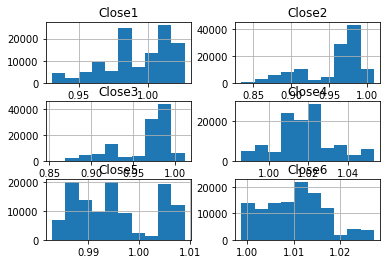

In [13]:
#Histograms
normalize_data(graphingDF).hist()
plt.show()

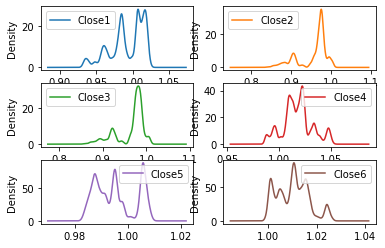

In [14]:
# Univariate Density Plots
normalize_data(graphingDF).plot(kind='density', subplots=True, layout=(3,2), sharex=False)
plt.show()

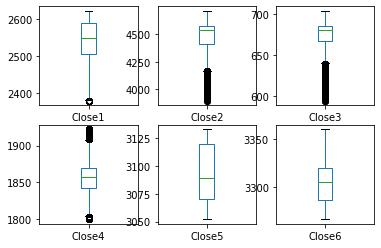

In [17]:
#Wiskers
graphingDF.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

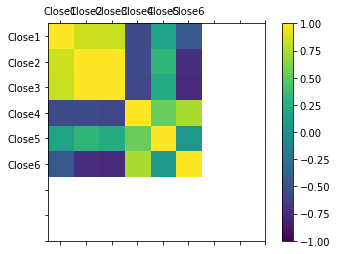

In [23]:
# Correction Matrix Plot
correlations = graphingDF.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
names = graphingDF.columns
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

#Shows instruments 2 and 3 have strongest (negative) correlation

In [9]:
############ BUILD DATAFRAME FOR MACHINE LEARNING #############
#Load data and build dataframe
trainingDataFrame = pd.DataFrame()

#loop over data files by instrument and day to form dataframe
days = range(3,7) # days of month: 3 - 6 inclusive (4-days)
instruments = range(1,7) # 6 instruments (6th is target)
for inst in instruments:
   
    colStr = 'c'+ str(inst)

    for day in days:
        #build data file name pattern
        fileName = "INST"+str(inst)+"_2018-12-0"+str(day)+".csv"
        
        df = pd.read_csv("CandlesData/"+fileName)

        #add date-time column as index ...below
        date = "2018-12-0"+str(day)+" "  #str w/ space
        hour = (np.floor(df['Seconds']/3600)).astype(int) #clean decimals
        minute = (np.floor(df['Seconds']/60 - hour*60)).astype(int)
        sec = df['Seconds'] - hour*3600 - minute*60

        #shift hour to market open 9:00am (assumption for my convinience)
        hour  = hour + 9
        
        #get leading zero when input one digit long
        def getLeadingZero(x):
            return np.where(len(str(x)) < 2, '0', '')

        #clean up seconds
        secLeadingZero = sec.apply(getLeadingZero)#get leading zero series
        cleanSec = secLeadingZero + sec.astype(str)  #add leading zero series
        #clean up minutes
        minLeadingZero = minute.apply(getLeadingZero) #like above
        cleanMinute =  minLeadingZero + minute.astype(str) #add leading zero series
        #clean up hour
        hrLeadingZero = hour.apply(getLeadingZero)
        cleanHour = hrLeadingZero + hour.astype(str)
        #build date string for pandas datetime obj as index
        dateString = date + cleanHour + ":" + cleanMinute +  ":" + cleanSec 
        
        from datetime import datetime
        df['dateTime'] = pd.to_datetime(dateString)#, format='%Y-%m-%d %H:%M:%S', errors='coerce', infer_datetime_format=True)
        
        #additional columns for training dataset: instrument, and cols for one-hot encoding
        cols = ['instrument','INST1','INST2','INST3','INST4','INST5','INST6'] #separate out INST6 as target

        #returns 0, 1 for one hot encoding, comparing index loop to col#
        def getOneHot(instStr, colName):
            s1 = colName[-1:] #take last char from colName i.e. digit
            s2 = instStr #inst str from loop index
            #print(s1+" "+s2)
            return np.where(s1 == s2, 1, 0)

        for col in cols:
            #for new col in list, populate col with 1's to indicate instrument else, zero for one hot encoding
            if(col!='instrument'):
                df[col] = getOneHot(str(inst),col)
            elif(col=='instrument'): #this column should aid in graphing
                df[col] = inst

        #rearrange column order
        cols = df.columns.tolist()
        cols = cols[-8:] + cols[:-8] #put last 7 cols in front
        df = df[cols] #assign reorder
        #print('file: '+fileName+' loaded; dataframe rows are: ' + str(len(df))) #six files have an extra second
        #if len(df)>28800:
            #print(df.tail())
        trainingDataFrame = pd.concat([trainingDataFrame, df])

trainingDataFrame = trainingDataFrame.sort_index()
#trainingDataFrame.info()
#print('Total trainingDataFrame rows: '+ str(len(trainingDataFrame))) #691206
#print('number of columns: '+str(len(trainingDataFrame.columns)))
#print('shape: ')
#trainingDataFrame.shape
#print('size')
#trainingDataFrame.size
#df.sum(axis = 0, skipna = True)     
trainingDataFrame

,dateTime,instrument,INST1,INST2,INST3,INST4,INST5,INST6,Seconds,High,Low,Open,Close,Qty
0,2018-12-03 09:00:00,1,1,0,0,0,0,0,0,2556.0,2556.0,2556.0,2556.0,1.0
0,2018-12-04 09:00:00,4,0,0,0,1,0,0,0,1850.0,1850.0,1850.0,1850.0,5.0
0,2018-12-04 09:00:00,3,0,0,1,0,0,0,0,690.0,690.0,690.0,690.0,1.0
0,2018-12-05 09:00:00,4,0,0,0,1,0,0,0,1844.0,1844.0,1844.0,1844.0,1.0
0,2018-12-05 09:00:00,6,0,0,0,0,0,1,0,3312.0,3312.0,3312.0,3312.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28800,2018-12-05 17:00:00,5,0,0,0,0,1,0,28800,3055.0,3055.0,3055.0,3055.0,4.0
28800,2018-12-05 17:00:00,3,0,0,1,0,0,0,28800,670.0,670.0,670.0,670.0,17.0
28800,2018-12-06 17:00:00,5,0,0,0,0,1,0,28800,3075.0,3075.0,3075.0,3075.0,33.0
28800,2018-12-03 17:00:00,2,0,1,0,0,0,0,28800,4475.0,4475.0,4475.0,4475.0,1.0


In [10]:
#log of change
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

,c1,c2,c3,c4,c5,c6,dateTime
0,2556.0,NaN,NaN,NaN,NaN,NaN,2018-12-03 09:00:00
1,2567.0,NaN,NaN,NaN,NaN,NaN,2018-12-03 09:00:01
2,2567.0,NaN,NaN,NaN,NaN,NaN,2018-12-03 09:00:02
3,2567.0,NaN,NaN,NaN,NaN,NaN,2018-12-03 09:00:03
4,2567.0,NaN,NaN,NaN,NaN,NaN,2018-12-03 09:00:04
...,...,...,...,...,...,...,...
28795,2588.0,4472.0,671.0,1887.0,3129.0,3324.0,2018-12-06 16:59:55
28796,2588.0,4472.0,671.0,1887.0,3129.0,3324.0,2018-12-06 16:59:56
28797,2588.0,4474.0,671.0,1887.0,3128.0,3324.0,2018-12-06 16:59:57
28798,2588.0,4474.0,671.0,1887.0,3128.0,3324.0,2018-12-06 16:59:58


Now, lets get the data ready for feeding to NN

In [8]:
#set dateTime as index
trainingDataFrame.set_index('dateTime',inplace=True)#drop=True, append=False, inplace=False, verify_integrity=False)

#trainingDataFrame.iloc[155000:155020]
#sort dataframe rows by datetime index
trainingDataFrame = trainingDataFrame.sort_index()



KeyError: ignored

In [14]:
trainingDataFrame.head(65)
#graphingDF.groupby(graphingDF.index)
#graphingDF#.head(65)


,instrument,INST1,INST2,INST3,INST4,INST5,INST6,Seconds,High,Low,Open,Close,Qty
dateTime,,,,,,,,,,,,,
2018-12-03 09:00:00,1,1,0,0,0,0,0,0,2556.0,2556.0,2556.0,2556.0,1.0
2018-12-03 09:00:00,5,0,0,0,0,1,0,0,3105.0,3105.0,3105.0,3105.0,2.0
2018-12-03 09:00:00,4,0,0,0,1,0,0,0,1825.0,1825.0,1825.0,1825.0,1.0
2018-12-03 09:00:00,3,0,0,1,0,0,0,0,696.0,696.0,696.0,696.0,2.0
2018-12-03 09:00:00,2,0,1,0,0,0,0,0,4670.0,4670.0,4670.0,4670.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-03 09:00:10,1,1,0,0,0,0,0,10,NaN,NaN,NaN,2567.0,NaN
2018-12-03 09:00:10,5,0,0,0,0,1,0,10,NaN,NaN,NaN,3105.0,NaN
2018-12-03 09:00:10,4,0,0,0,1,0,0,10,NaN,NaN,NaN,1856.0,NaN


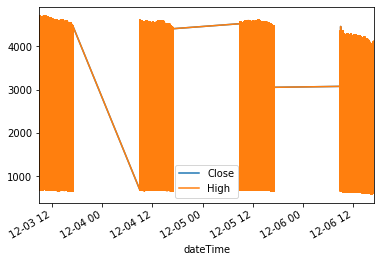

In [0]:
#graph
trainingDataFrame[['Close', 'High']].plot()
plt.show()
#build dataset to graph - look at close of each series, vs time
#ds = pd.DataFrame(getColData(i),columns=['c1','c2','c3','c4','c5','c6'])

#cp = (trainingDataFrame['Close'].where(trainingDataFrame['instrument']==1)).copy()
#cp.dropna(0,inplace=True)
#ds = pd.DataFrame(cp.copy().tolist(),columns=['c1'],index=0)
#ds = cp.copy()
#ds.rename(columns={ ds.columns[1]: "c1" }, inplace = True)
#gds = trainingDataFrame[['instrument','Close']]
#ds['c1']=trainingDataFrame['Close']
# making boolean series for a team name 
#filter = trainingDataFrame['instrument']==1
# filtering data 
#ds = trainingDataFrame.where(filter, inplace = True) 
#drop rows that are all NaN
#ds.dropna(0, how='all', subset=['c1'], inplace=True)
#
#ds.drop(columns=['Close','Qty'])
#dataset.drop('No', axis=1, inplace=True)
#len(ds.index)
#print(ds.tail(22))

#import seaborn as sns
#sns.pairplot(gds)
#ds

J Welles Wilder chose CHXX as best representative pair of possibilities to represent __________. Why? The answer presented in a separate article may be relevant to choice of col to feed to NN. For example, instructions given orally were to use instruments 1 through 5 as predictors of inst6 (target). Therefore, inst6 will not be used as a feature. It would be interesting to examine how prediction accuracy is affected by including inst6 as feature in addition to being target. Percaution is needed to avoid look ahead bias error.





Graph for visual inspection

In [0]:

import seaborn as sns


NameError: ignored

PREPARE DATA
- combine training data into one large set. Instrument being categorical, is converted to one-hot encoding. Normalize data for ML PCA

In [0]:
bla

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 5s 168ms/step - loss: 21.4949 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 21.1128 - mae: 21.6440
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 20.7468 - mae: 21.2278
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 20.3564 - mae: 20.7739
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 19.7907 - mae: 20.2843
Epoch 6/100
31/31 [==============================] - 1s 32ms/step - loss: 19.1428 - mae: 19.6776
Epoch 7/100
31/31 [==============================] - 1s 32ms/step - loss: 18.2205 - mae: 18.7308
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 17.5280 - mae: 17.9757
Epoch 9/100
31/31 [==============================] - 1s 33ms/step - loss: 17.1315 - mae: 17.6581
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 16.8294 - mae: 17.3457
Epoch 11/100
31/31 [========

[1e-08, 0.0001, 0, 30]

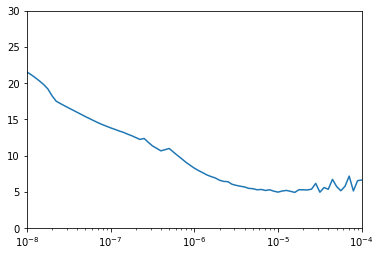

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

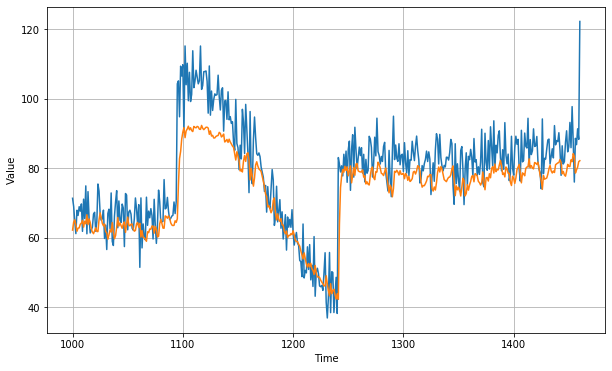

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.514286

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

KeyError: ignored

In [0]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [0]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)